In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import itertools
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [3]:
import classifier_utils as utils

In [22]:
reload(utils)

<module 'classifier_utils' from 'classifier_utils.py'>

# Get Dataset

In [44]:
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]

train, test = utils.get_augmented_dataset_divided_per_image(categories)

Dropped 1559 patches because too close to image border
Dropped 523 patches because too close to image border


In [45]:
for (k, v) in train.iteritems():
    print "train", k, v.shape
for (k, v) in test.iteritems():
    print "test", k, v.shape

train hsv_factors (60000, 3)
train deltas (60000, 2)
train patches (60000, 27, 27, 3)
train rots (60000,)
train labels (60000, 4)
train flips (60000,)
train centres (60000, 2)
train img_ids (60000,)
test img_ids (4593,)
test labels (4593, 4)
test patches (4593, 27, 27, 3)
test centres (4593, 2)


In [46]:
# Sanity-check that the test and train data come from different images
test_img_ids = set(test['img_ids'])
train_img_ids = set(train['img_ids'])
print "Train:", sorted(train_img_ids)
print "Test:", sorted(test_img_ids)
print "Intersection:", sorted(train_img_ids.intersection(test_img_ids))

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 40, 41, 42, 43, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 66, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99]
Test: [9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64, 65, 67, 70, 81, 83, 87, 88, 96]
Intersection: []


In [47]:
# DELETE ME
# Temp for spot check
(all_imgs, _, _) = utils.get_dataset(100, categories)

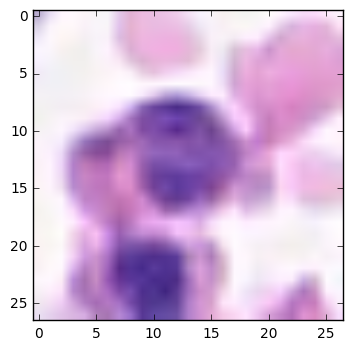

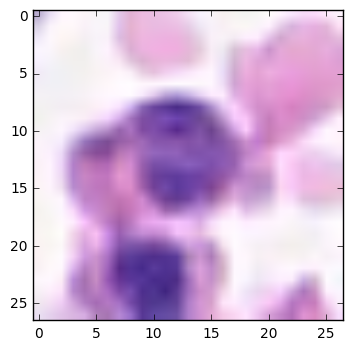

In [48]:
# DELETE ME
# Spot check
i = 420
plt.figure()
plt.imshow(test['patches'][i])
(x, y) = test['centres'][i]
img_id = test['img_ids'][i]
img = all_imgs[img_id]
plt.figure()
plt.imshow(img[y-13:y+14,x-13:x+14])

# Train a Softmax CNN Model

In [ ]:
try:
    sess.close()
except:
    pass # sess doesn't exist yet!

tf.reset_default_graph()
sess = tf.InteractiveSession()

patch_model = SoftmaxCNNModel()

In [ ]:
num_epochs = 20
batch_size = 100
tr_loss, tst_loss = patch_model.train_loop(sess,
                                           train['patches'],
                                           train['labels'],
                                           test['patches'],
                                           test['labels'],
                                           num_epochs,
                                           batch_size)